###`Import necessary libraries for data scraping, processing, and model building.The stock index name and fetch its historical data from Yahoo Finance.`

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf

# ---- 1. Fetch Stock Data ----
stk_name = input("Enter Stock Ticker (e.g., AAPL): ")
start = input("Start Date (YYYY-MM-DD): ")
end = input("End Date (YYYY-MM-DD): ")

# Download data using yfinance
df = yf.download(stk_name, start=start, end=end)
df.columns = df.columns.droplevel(1)  # Remove multi-index (ticker name)
df.columns.name = None
df = df.reset_index()
df

Enter Stock Ticker (e.g., AAPL): INFY.NS
Start Date (YYYY-MM-DD): 1981-07-31
End Date (YYYY-MM-DD): 2025-07-31


/tmp/ipython-input-2984116194.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stk_name, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,1996-01-01,0.511998,0.511998,0.508358,0.510868,204800
1,1996-01-02,0.509927,0.513379,0.509927,0.510868,204800
2,1996-01-03,0.513379,0.513379,0.513379,0.513379,102400
3,1996-01-04,0.509990,0.510868,0.508358,0.508358,307200
4,1996-01-05,0.503965,0.503965,0.503965,0.503965,51200
...,...,...,...,...,...,...
7424,2025-07-24,1552.500000,1582.000000,1548.199951,1580.000000,14169664
7425,2025-07-25,1515.699951,1549.500000,1511.300049,1543.400024,10851259
7426,2025-07-28,1516.000000,1519.300049,1482.500000,1513.900024,6439855
7427,2025-07-29,1513.699951,1517.199951,1496.099976,1512.900024,7070448


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429 entries, 0 to 7428
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7429 non-null   datetime64[ns]
 1   Close   7429 non-null   float64       
 2   High    7429 non-null   float64       
 3   Low     7429 non-null   float64       
 4   Open    7429 non-null   float64       
 5   Volume  7429 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 348.4 KB


### `Data Inspection`

### `Visualizing the Stock Trend`

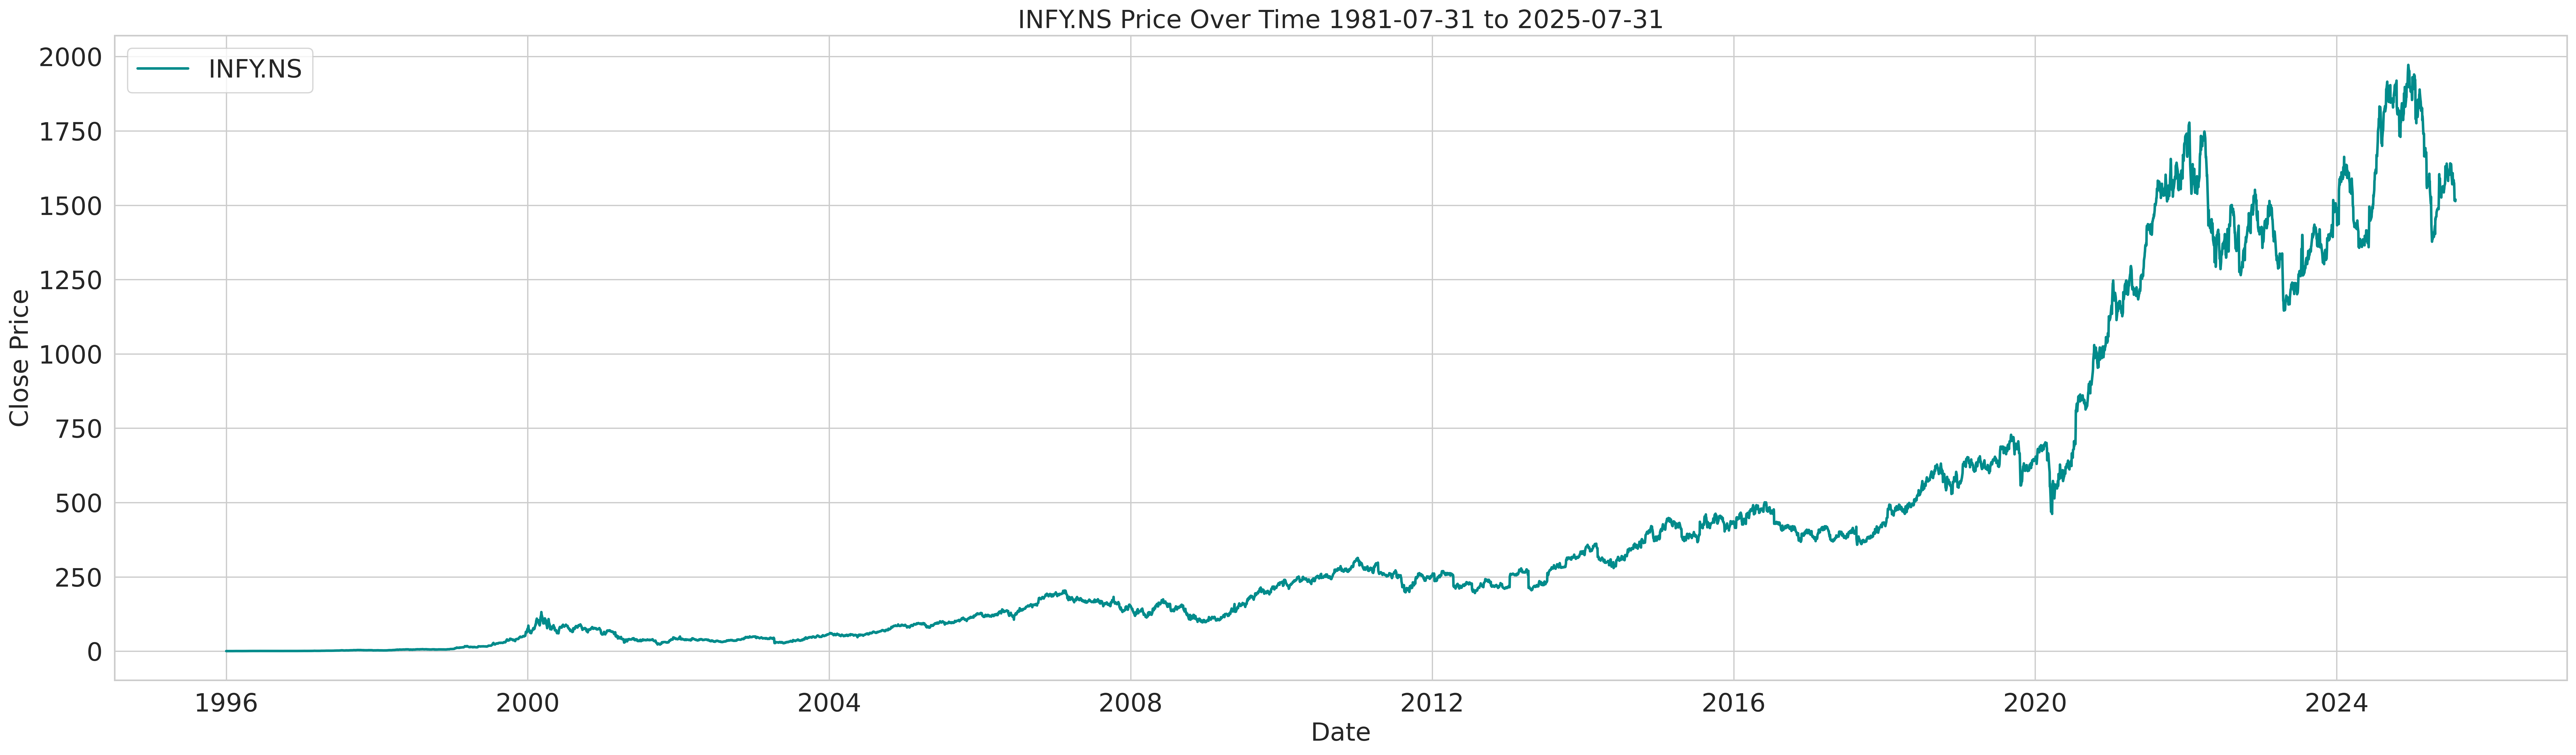

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set Seaborn style
sns.set_theme(style="whitegrid")
# Create the plot
plt.figure(figsize=(28.45, 8.45), dpi=350)
sns.lineplot(data=df, x='Date', y='Close', label=f'{stk_name}', color='darkcyan', linewidth=2)
plt.title(f'{stk_name} Price Over Time {start} to {end}', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price', fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

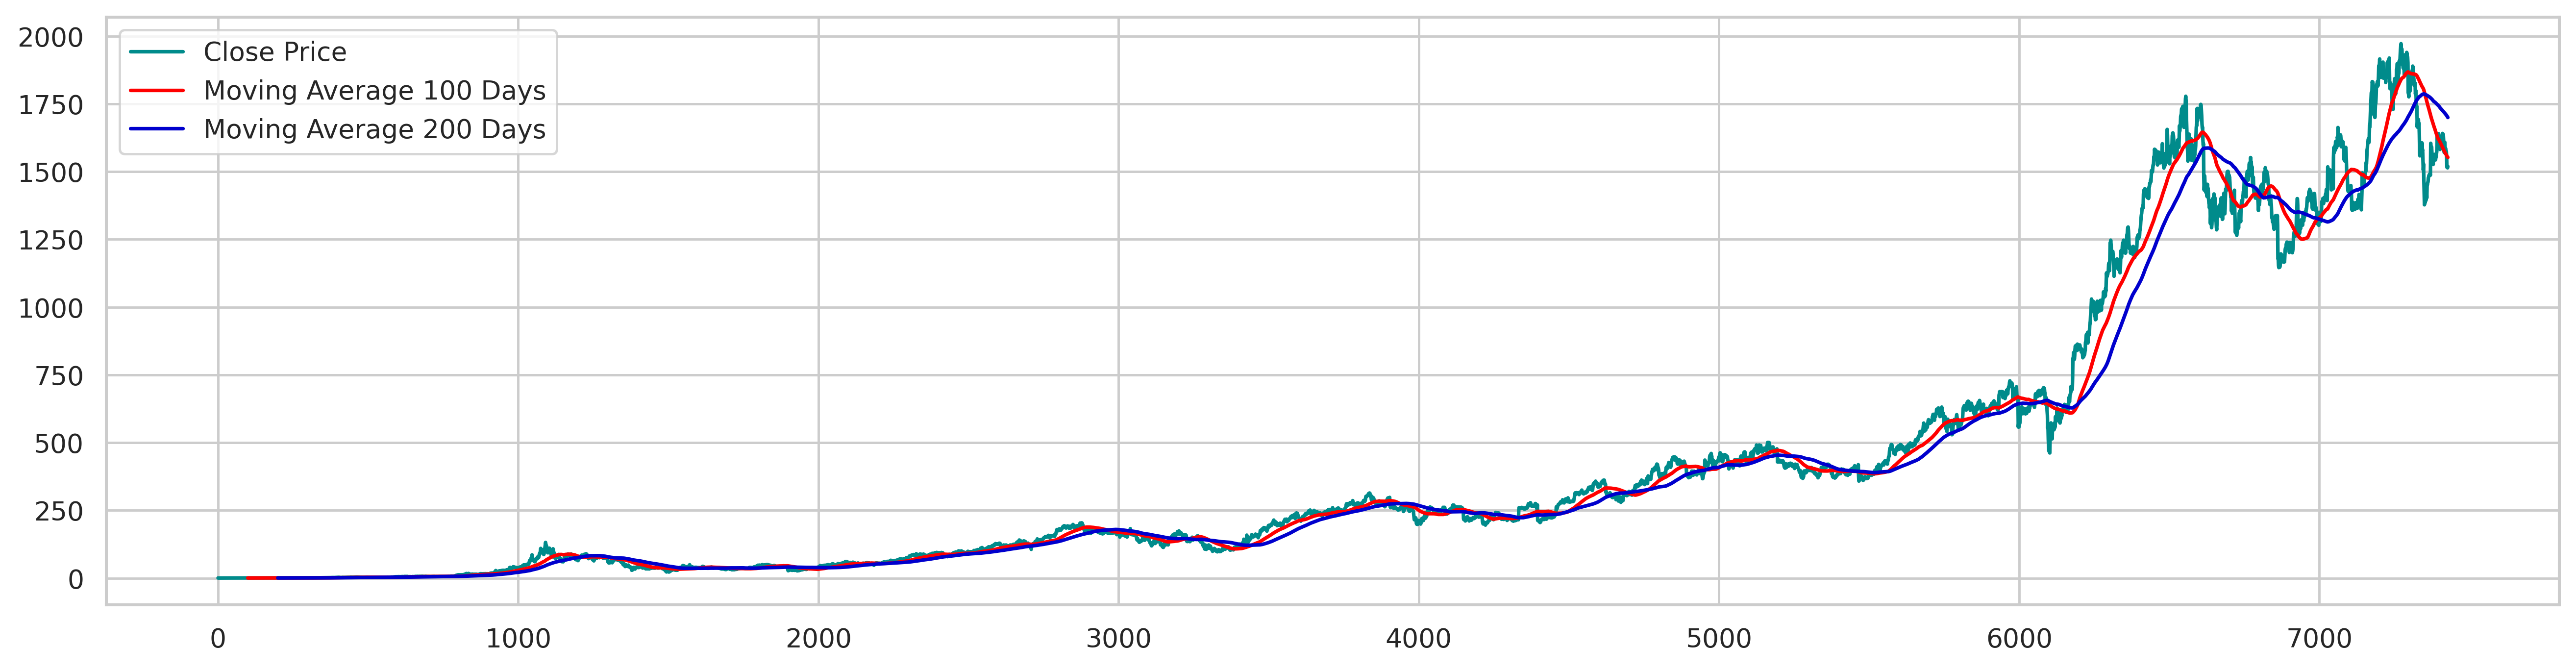

In [ ]:
ma_100_days = df['Close'].rolling(100).mean()
ma_200_days = df['Close'].rolling(200).mean()
# Create the plot
plt.figure(figsize=(18.45, 4.45), dpi=350)
plt.plot(df.Close, 'darkcyan', label = "Close Price")
plt.plot(ma_100_days, 'red', label = "Moving Average 100 Days")
plt.plot(ma_200_days, 'mediumblue', label = "Moving Average 200 Days")
plt.legend()
plt.grid('off')
plt.show()

<Axes: ylabel='Close'>

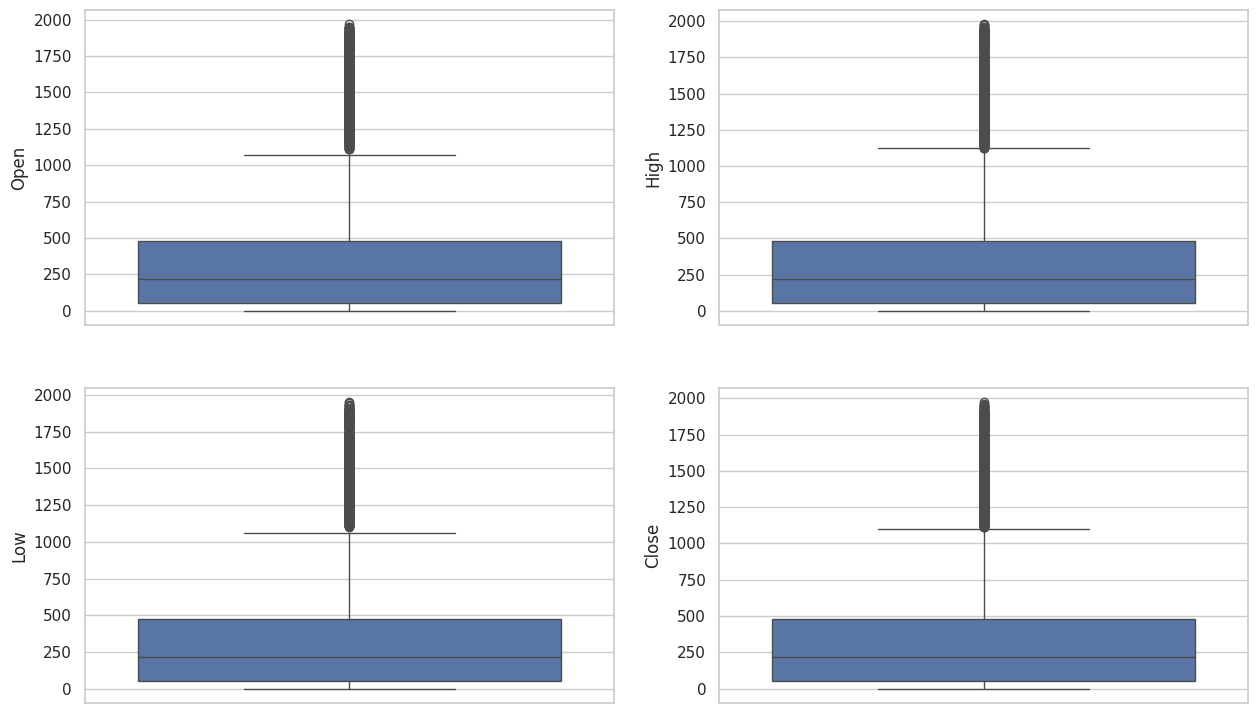

In [ ]:
plt.figure(figsize=(15, 9))
plt.subplot(2, 2,1)
sns.boxplot(df['Open'])
plt.subplot(2, 2, 2)
sns.boxplot(df['High'])
plt.subplot(2, 2, 3)
sns.boxplot(df['Low'])
plt.subplot(2, 2, 4)
sns.boxplot(df['Close'])

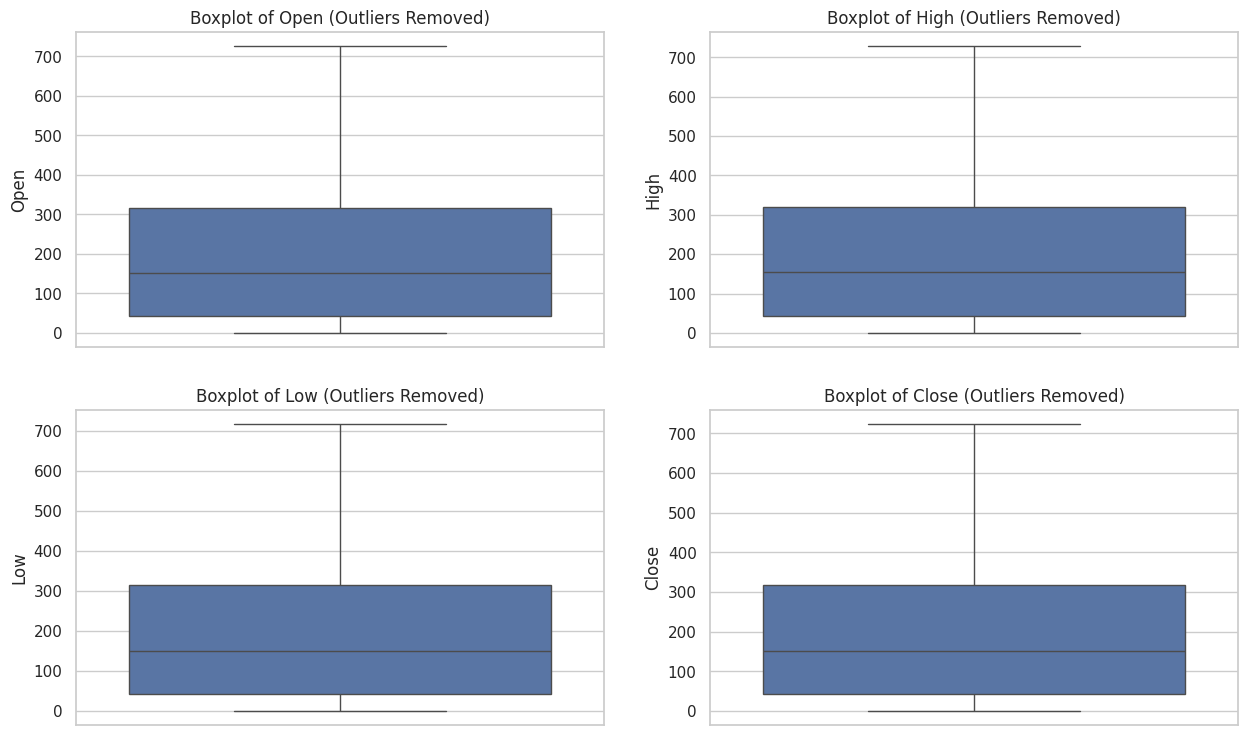

In [ ]:
# List of target columns
columns = ['Open', 'High', 'Low', 'Close']

# Function to remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
df_clean = remove_outliers(df, columns)

# Plot cleaned data
plt.figure(figsize=(15, 9))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(df_clean[col])
    plt.title(f'Boxplot of {col} (Outliers Removed)')

plt.show()

<Axes: xlabel='Close', ylabel='Count'>

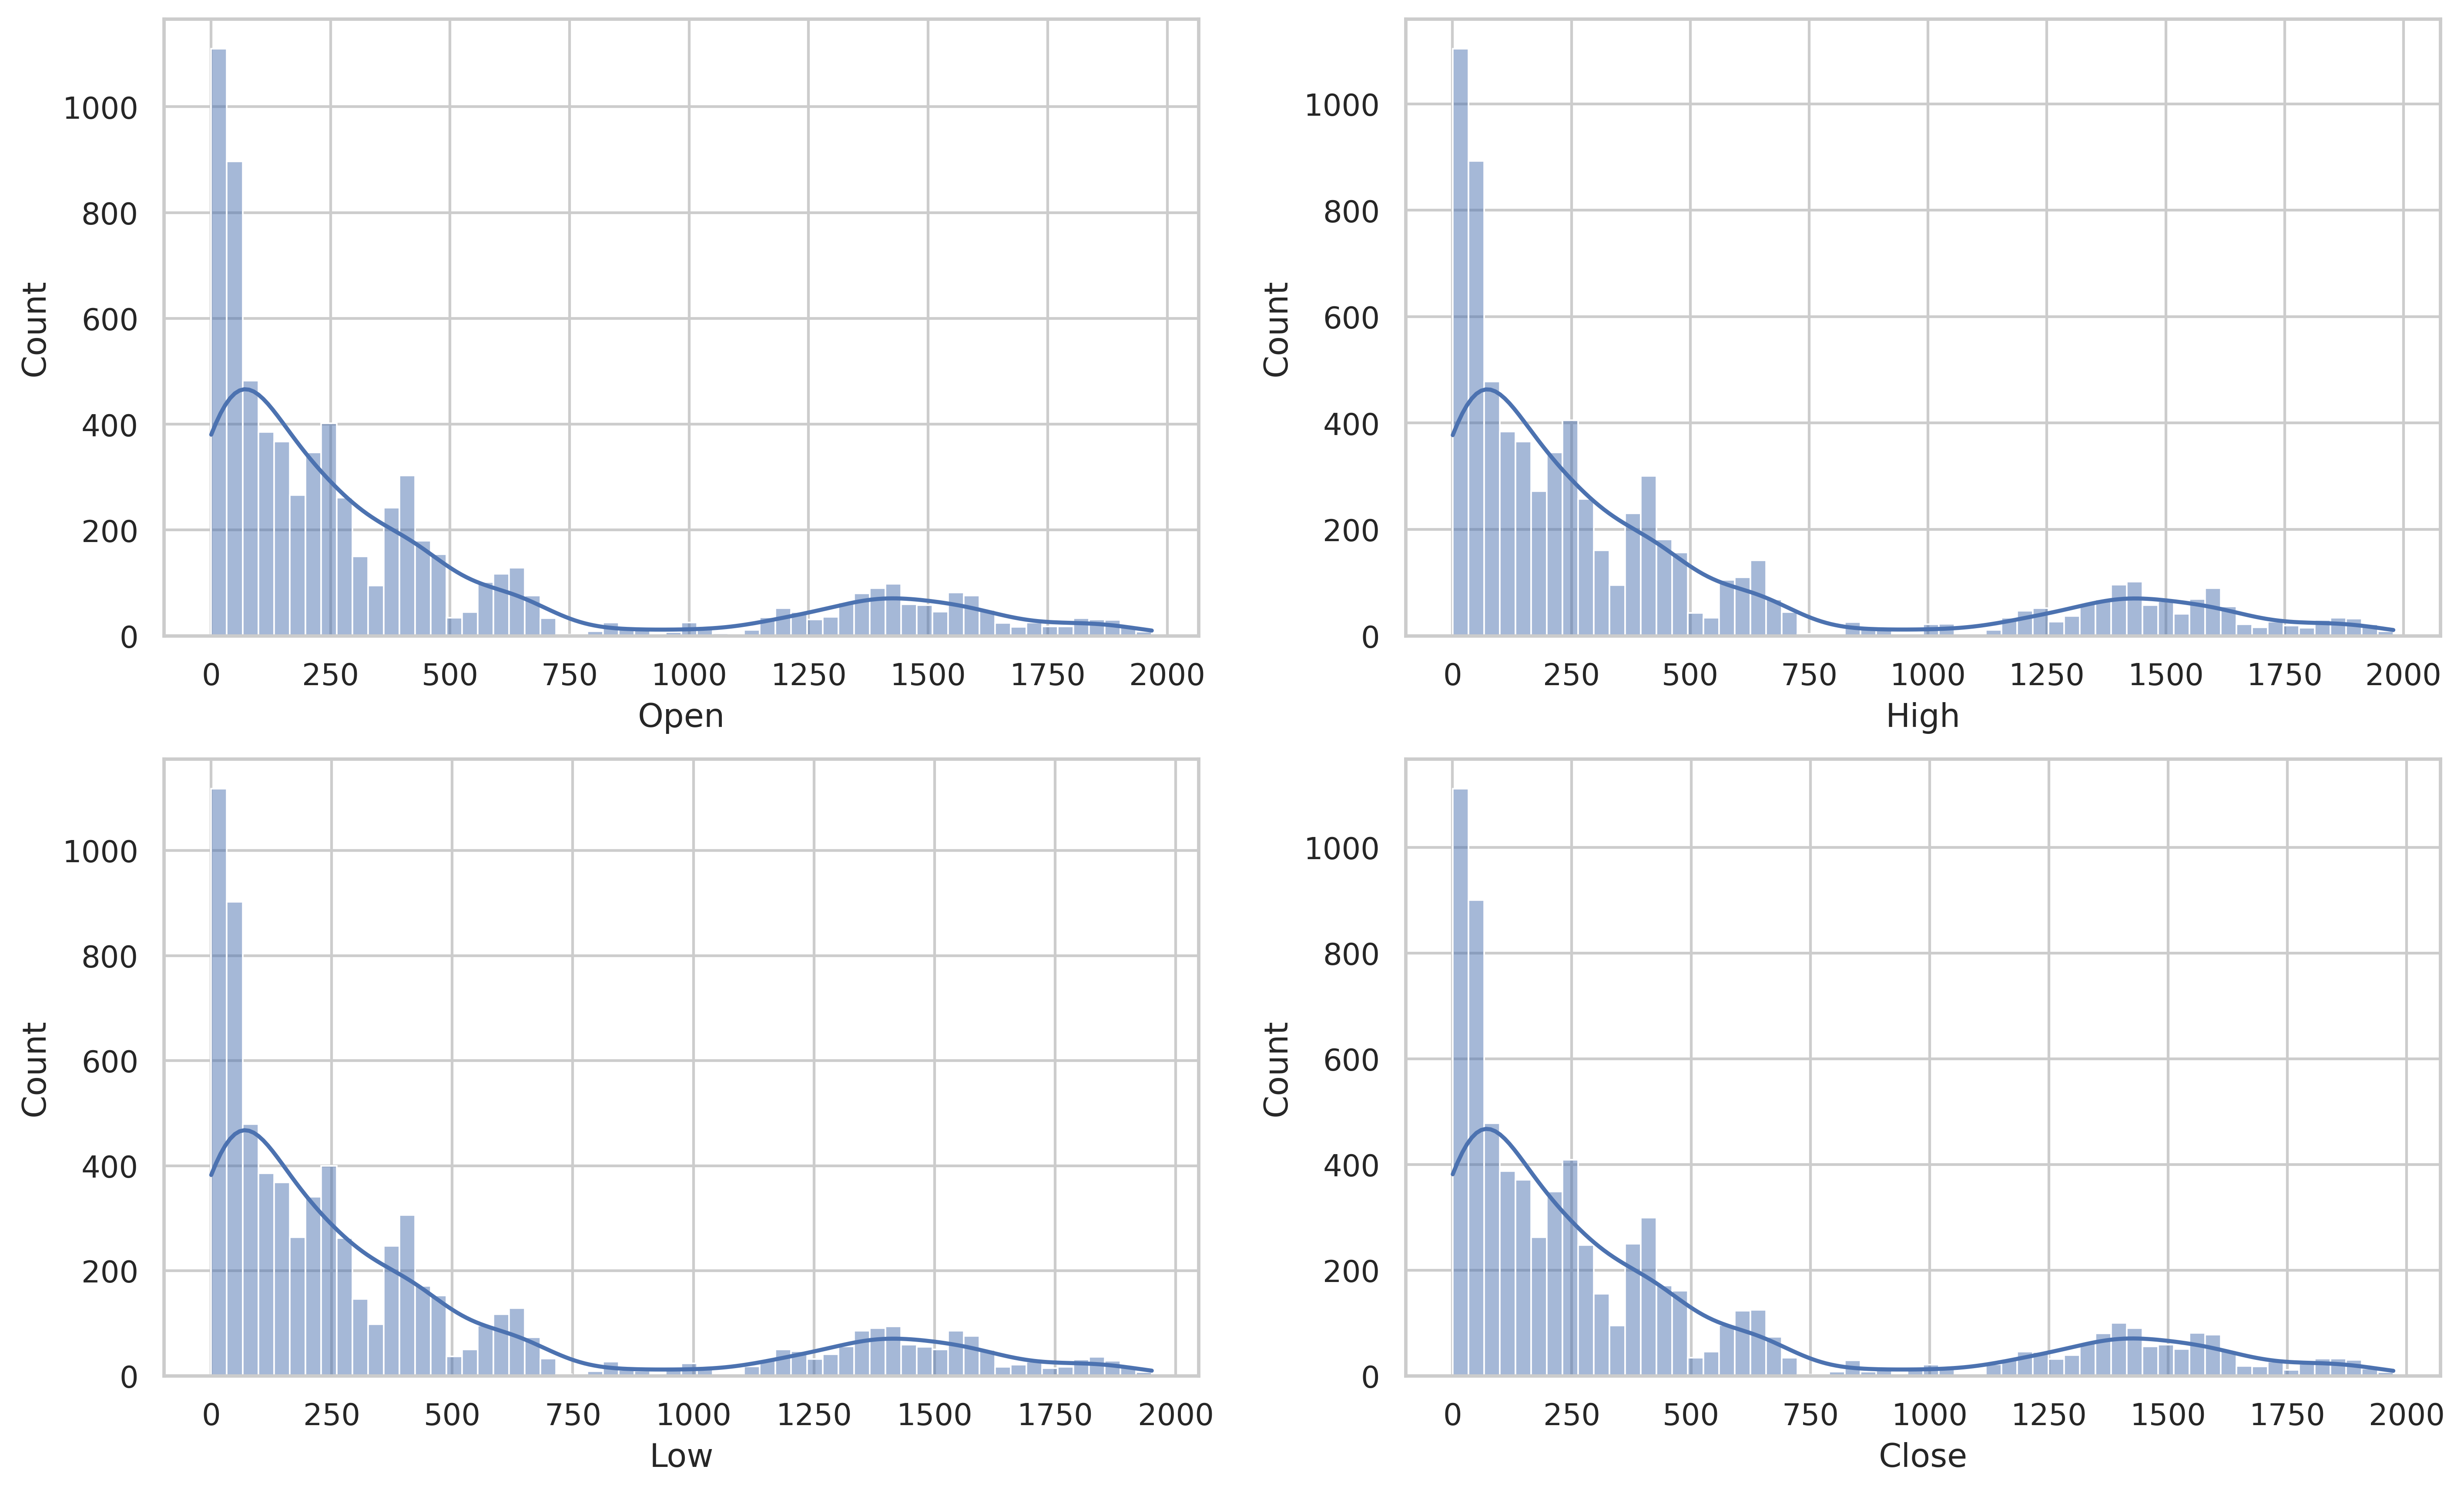

In [ ]:
plt.figure(figsize=(15, 9), dpi=450)
plt.subplot(2, 2,1)
sns.histplot(df['Open'], kde=True, line_kws={'color': 'blue'}, bins=60)
plt.subplot(2, 2, 2)
sns.histplot(df['High'], kde=True, line_kws={'color': 'blue'}, bins=60)
plt.subplot(2, 2, 3)
sns.histplot(df['Low'], kde=True, line_kws={'color': 'blue'}, bins=60)
plt.subplot(2, 2, 4)
sns.histplot(df['Close'], kde=True, line_kws={'color': 'blue'}, bins=60)

<Axes: >

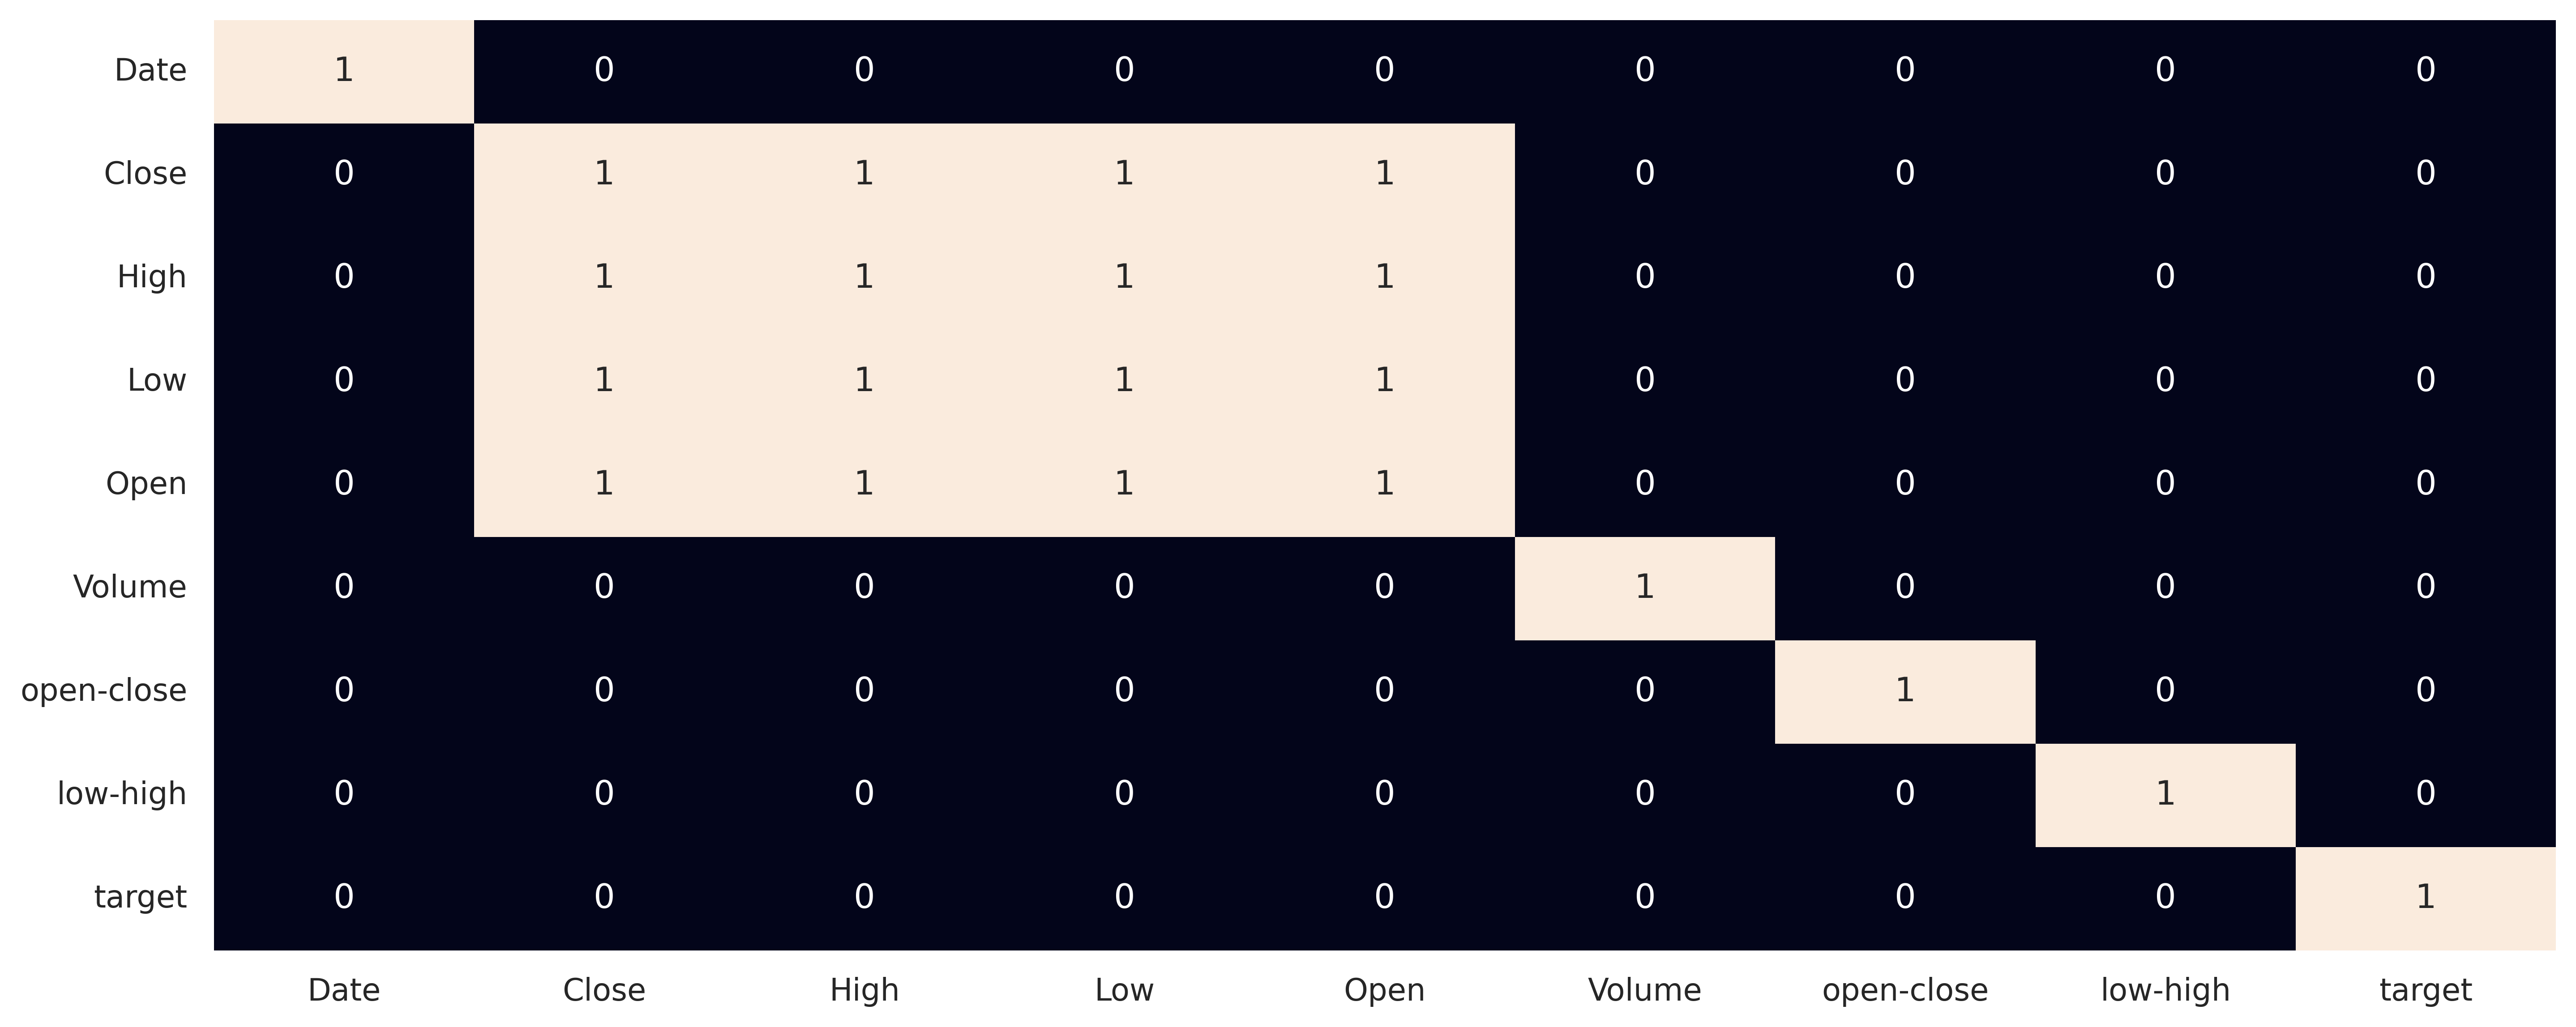

In [ ]:
import numpy as np

df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
#numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(15, 6), dpi=450)
sns.heatmap(df.corr()>0.9, annot=True, cbar=False)

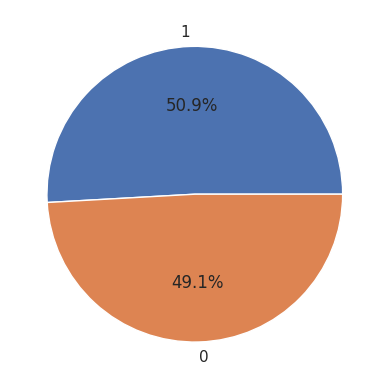

In [ ]:
plt.pie(df['target'].value_counts().values,
        labels=df['target'].value_counts().index, autopct='%1.1f%%')
plt.show()

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Select features (independent variables) and target (dependent variable)
X = df[['Open', 'Close', 'Volume', 'open-close', 'low-high']]  # Features
Y = df['target']  # Target variable (binary classification: 0 or 1)

# Split the dataset into training and testing sets
# - 70% of the data is used for training, 30% for testing
# - random_state ensures reproducibility of the split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=200)

# Initialize the Random Forest Classifier with a fixed random_state for reproducibility
model = RandomForestClassifier(random_state=200)

# Train the model using the training dataset
model.fit(X_train, Y_train)

# Predict the target labels for the test dataset
Y_predict = model.predict(X_test)

# Calculate the accuracy score
# - Accuracy represents the proportion of correct predictions out of all predictions
accuracy = accuracy_score(Y_test, Y_predict)
print(f'Accuracy Score:{accuracy:.2f}')  # Display the accuracy with two decimal places

# Generate a classification report
# - The classification report includes precision, recall, F1 score, and support for each class
report = classification_report(Y_test, Y_predict)
print(f'Classification Report:\n{report}\n')


Accuracy Score:0.50
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      1121
           1       0.50      0.51      0.50      1108

    accuracy                           0.50      2229
   macro avg       0.50      0.50      0.50      2229
weighted avg       0.50      0.50      0.50      2229




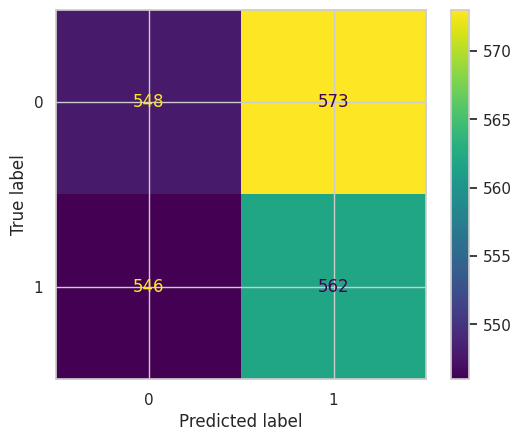

In [ ]:
cm = confusion_matrix(Y_test, Y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### `Data Preprocessing for Prediction and Preparing Data for LSTM Model`

In [ ]:
df = df.sort_values("Date")

# Select only Close price for prediction
data = df[["Close"]].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of past days to consider)
SEQ_LENGTH = 50

# Prepare training data
X, y = create_sequences(data_scaled, SEQ_LENGTH)
# Split into training (80%) and testing (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



### `Splitting Data and Training LSTM Model`

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])



# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 1.1993e-04 - val_loss: 0.0012
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 8.2546e-05 - val_loss: 9.6507e-04
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 8.5964e-05 - val_loss: 0.0043
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 8.3279e-05 - val_loss: 5.1714e-04
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 7.3697e-05 - val_loss: 6.2443e-04
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 7.5798e-05 - val_loss: 4.7846e-04
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 6.9283e-05 - val_loss: 5.1455e-04
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 7.2925e-05 - val_loss: 4.9400e-04
Epoch 10/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 7.4325e-05 - val_loss: 4.1403e-04
Epoch 11/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 7.8454e-

### `Visualizing Actual vs Predicted Stock Prices`

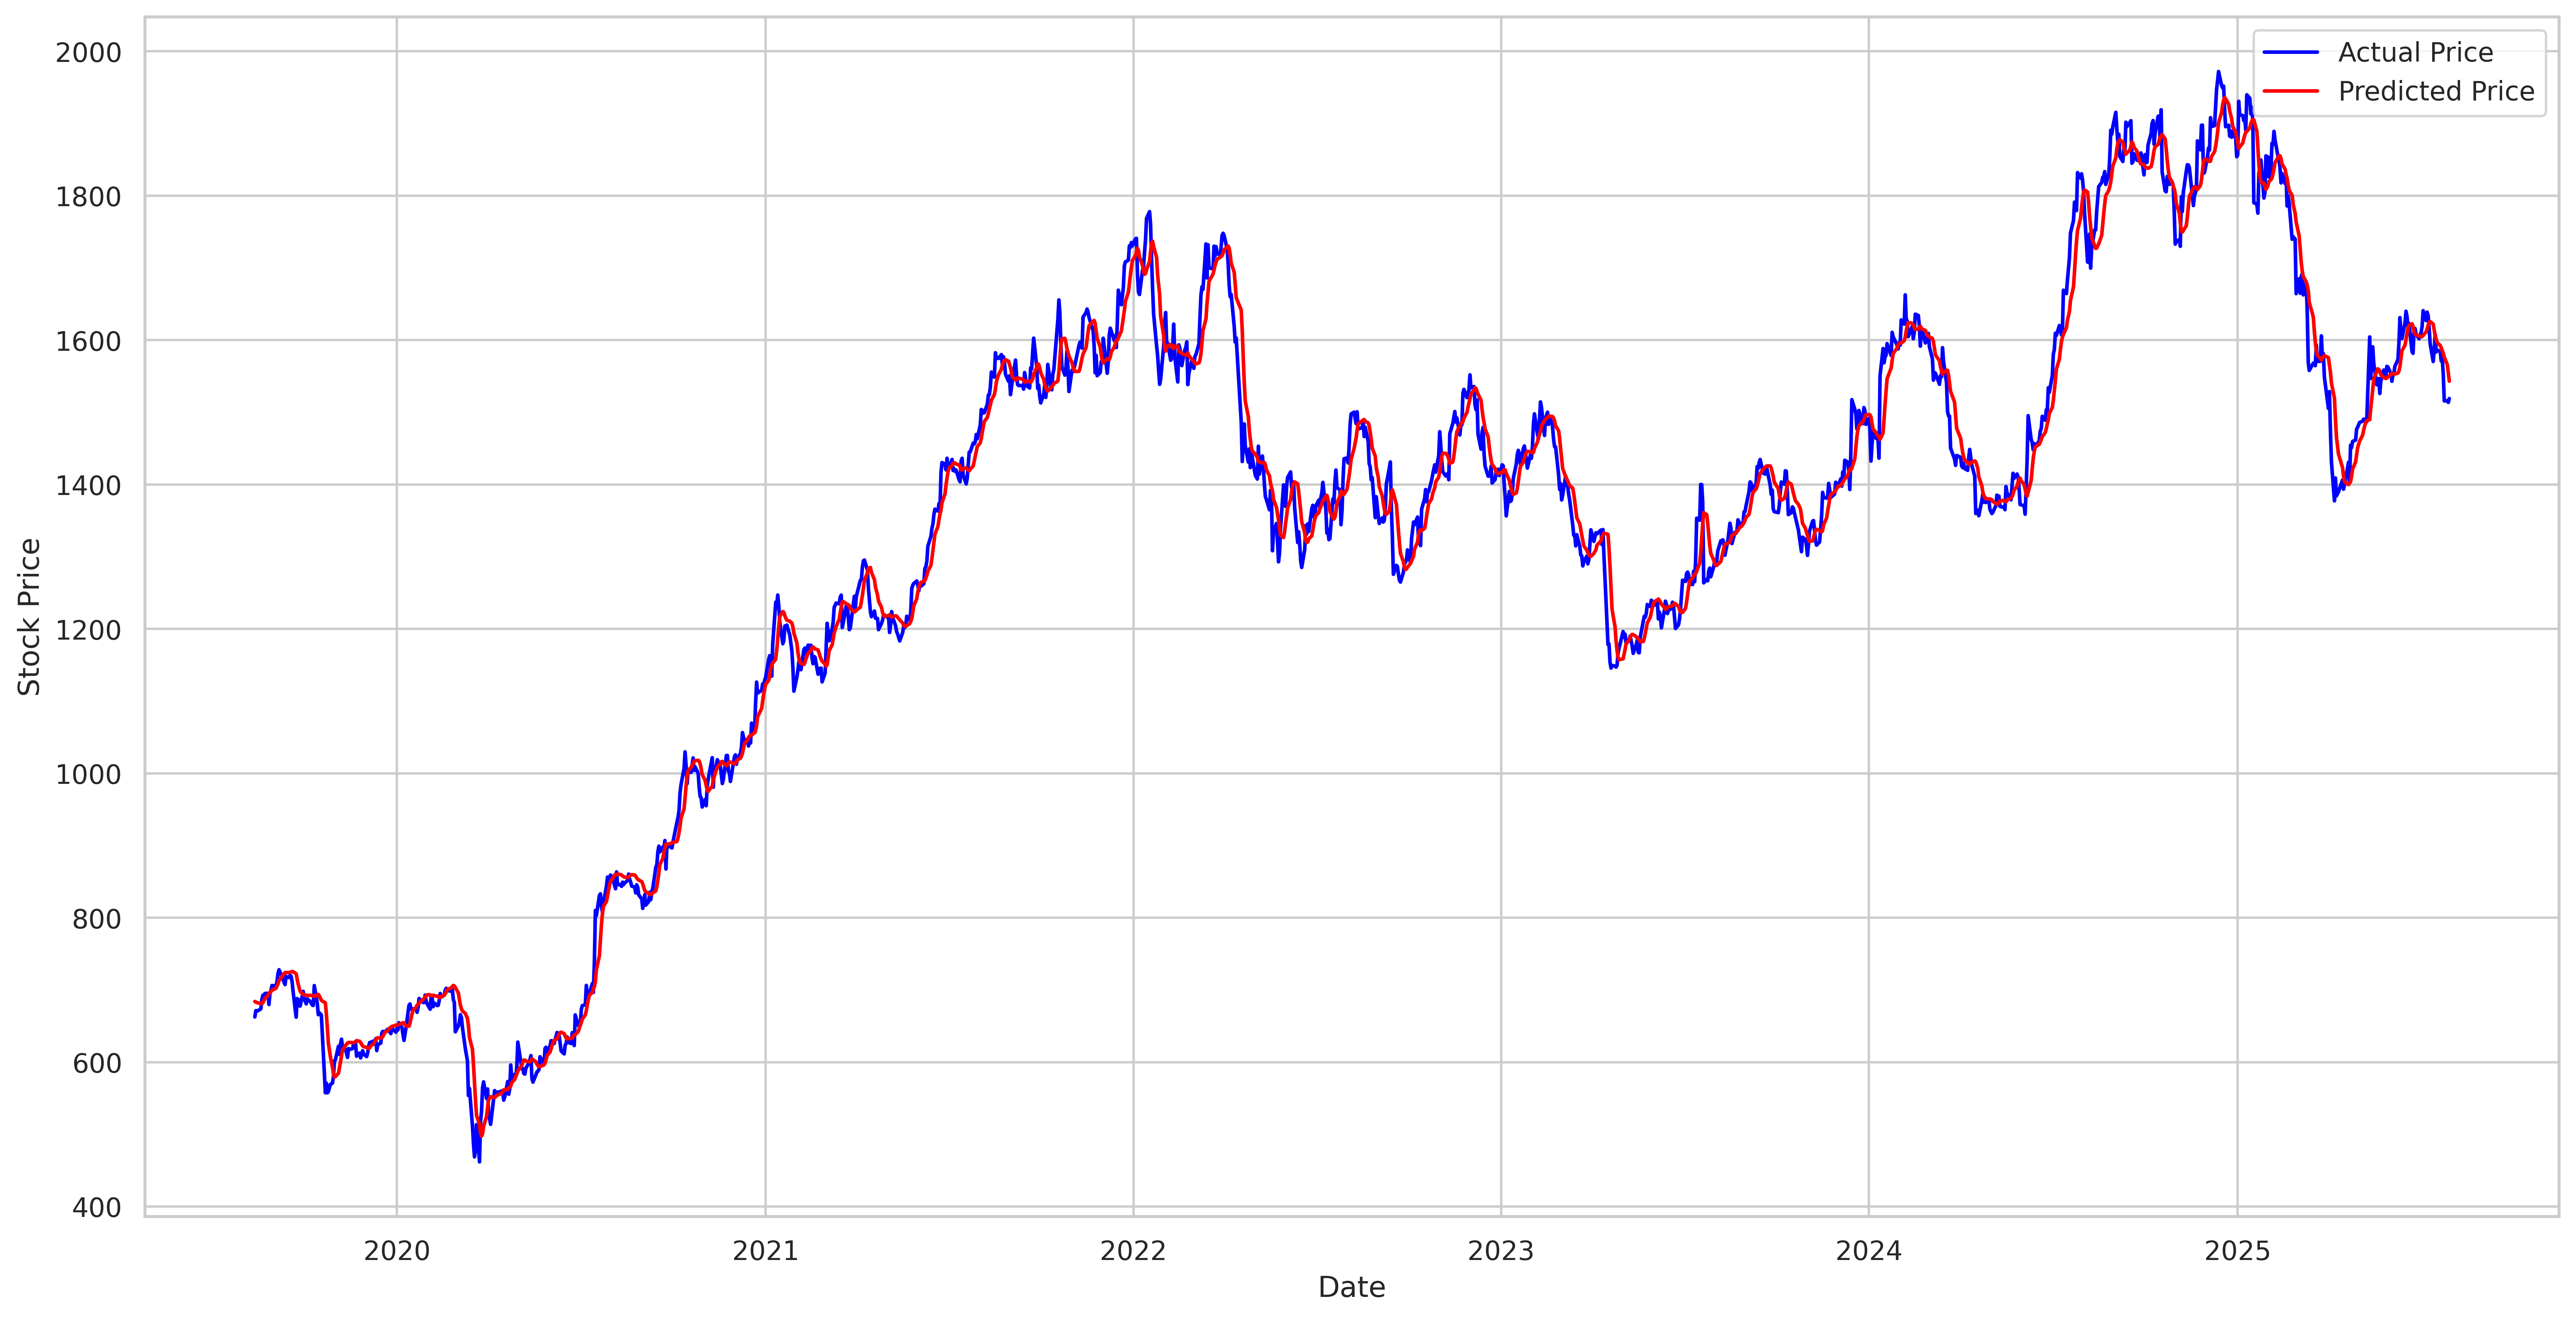

In [ ]:
# Plot results
plt.figure(figsize=(18, 9), dpi=450)
plt.plot(df["Date"].iloc[-len(y_test):], scaler.inverse_transform(y_test), label="Actual Price", color="blue")
plt.plot(df["Date"].iloc[-len(predictions):], predictions, label="Predicted Price", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

### `Predicting Stock Prices for the Next 10 Days`

In [ ]:
# Predict next 10 days
future_data = X_test[-1].reshape(1, SEQ_LENGTH, 1)
future_predictions = []
for _ in range(10):
    pred_price = model.predict(future_data)[0][0]
    future_predictions.append(pred_price)
    new_entry = np.append(future_data[:, 1:, :], [[[pred_price]]], axis=1)  # Shift window
    future_data = new_entry

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Predicted Prices for Next 10 Days:")
print(future_predictions.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Prices for Next 10 Days:
[1543.1135 1537.0762 1533.9261 1532.3965 1531.7473 1531.5599 1531.6036
 1531.755  1531.9498 1532.1571]


In [ ]:
# Get the last actual closing price
last_actual_price = scaler.inverse_transform(X_test[-1][-1].reshape(-1, 1))[0][0]

# First and last predicted price
first_pred_price = future_predictions[0][0]
last_pred_price = future_predictions[-1][0]

# Calculate expected profit/loss over 10 days
price_change = last_pred_price - last_actual_price
status = "Profit" if price_change > 0 else "Loss"

print(f"\nLast Actual Price: ₹{last_actual_price:.2f}")
print(f"Predicted Price After 10 Days: ₹{last_pred_price:.2f}")
print(f"Expected {status} of ₹{abs(price_change):.2f} in 10 days.")


Last Actual Price: ₹1513.70
Predicted Price After 10 Days: ₹1532.16
Expected Profit of ₹18.46 in 10 days.


### Save this model

In [ ]:
model.save('Stock_prediction_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('Stock_prediction_model.keras')

## Let’s Try My Stock Prediction Model!
## Enter a stock ticker and date range to forecast the next 10 days — and see if we’re heading for a profit or a loss! 📈📉

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from datetime import datetime

# --- USER INPUT ---
ticker = input("Enter stock ticker (e.g., RELIANCE.NS): ")
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

# --- LOAD DATA ---
df = yf.download(ticker, start=start_date, end=end_date)
if df.empty or 'Close' not in df.columns:
    raise ValueError("Stock data not available or invalid ticker/date range.")

data = df[['Close']].values

# --- SCALE DATA ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# --- PREPARE SEQUENCE ---
SEQ_LENGTH = 60
# Adjust SEQ_LENGTH if data is shorter
if len(scaled_data) < SEQ_LENGTH + 1:
    print(f"Warning: Not enough data for SEQ_LENGTH of {SEQ_LENGTH}. Adjusting SEQ_LENGTH to {len(scaled_data) - 1}.")
    SEQ_LENGTH = len(scaled_data) - 1
    if SEQ_LENGTH <= 0:
        raise ValueError("Not enough data to create sequences. Please select a longer date range.")

X_test = []
for i in range(SEQ_LENGTH, len(scaled_data)):
    X_test.append(scaled_data[i-SEQ_LENGTH:i])

X_test = np.array(X_test)

# --- LOAD MODEL ---
model = load_model('Stock_prediction_model.keras')

# --- PREDICT FUTURE ---
future_data = X_test[-1].reshape(1, SEQ_LENGTH, 1)
future_predictions = []
for _ in range(10):
    pred_price = model.predict(future_data, verbose=0)[0][0]
    future_predictions.append(pred_price)
    future_data = np.append(future_data[:, 1:, :], [[[pred_price]]], axis=1)

# --- INVERSE TRANSFORM ---
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# --- OUTPUT ---
last_actual_price = scaler.inverse_transform(X_test[-1][-1].reshape(-1, 1))[0][0]
last_pred_price = future_predictions[-1][0]
change = last_pred_price - last_actual_price
status = "Profit" if change > 0 else "Loss"


print("\nPredicted Prices for Next 10 Days:")
next_10_dates = [df.index[-1].date() + timedelta(days=i) for i in range(2, 11)]
for date, price in zip(next_10_dates, future_predictions.flatten()):
    print(f"{date}: ₹{price:.2f}")

print(f"\nLast Actual Price: ₹{last_actual_price:.2f}")
print(f"Predicted Price After 10 Days: ₹{last_pred_price:.2f}")
print(f"Expected {status} of ₹{abs(change):.2f} in 10 days.")

Enter stock ticker (e.g., RELIANCE.NS): ITC.NS
Enter start date (YYYY-MM-DD): 2025-01-01
Enter end date (YYYY-MM-DD): 2025-07-31


/tmp/ipython-input-4157437259.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



Predicted Prices for Next 10 Days:
2025-08-01: ₹412.91
2025-08-02: ₹411.94
2025-08-03: ₹411.45
2025-08-04: ₹411.24
2025-08-05: ₹411.16
2025-08-06: ₹411.17
2025-08-07: ₹411.22
2025-08-08: ₹411.28
2025-08-09: ₹411.36

Last Actual Price: ₹408.45
Predicted Price After 10 Days: ₹411.44
Expected Profit of ₹2.99 in 10 days.
